## 課題
1. 20件それぞれのSIFを計算する
2. MT法で異常値を検出する
3. 閾値を超えたデータがあれば、異常度が最も大きなデータを削除する(9件目)
4. 残りの19件を全データとして、もう一度SIFを計算せよ
5. MT法で異常値を検出して、閾値を超えるデータはあるか
6. 繰り返し

In [1]:
%load_ext autoreload
%autoreload 2

from pandas import DataFrame
from scipy.stats import chi2
from typing import Callable
import numpy as np

# 自作モジュール
from dataloader import AssignmentData
from visualizer import Drawer, TableVisualizer
from sif_simulator import SifSimulator
from measure import MahalanobisDistance2, mahalanobis_distances2
from linear_regression import SimpleLinearRegression, extended_linspace, Parameter

## 1. 準備

#### 1-1. データ読み込み

In [2]:
path = "./data/students_height_and_sitting_height.csv"
data = AssignmentData(path)
df = data.get_data()
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
height,159,150,157,153,158,152,155,157,145,158,161,150,148,154,154,159,149,155,153,160
sitting height,88,84,86,81,83,85,83,83,76,85,85,83,79,84,85,85,83,86,84,88


#### 1-2. データ可視化

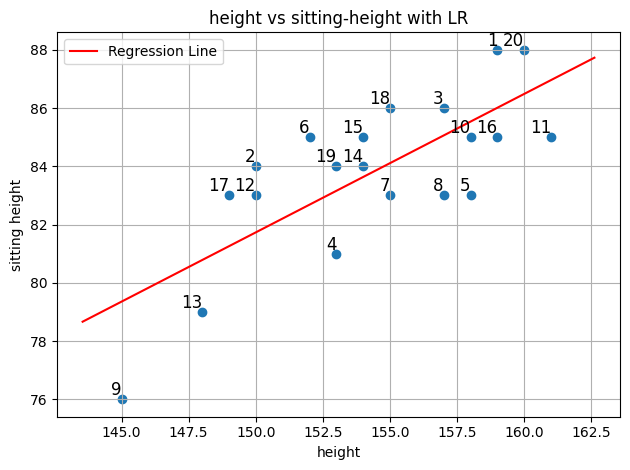

傾き: 0.4756549170209848 / 切片: 10.382663557811


In [3]:
model = SimpleLinearRegression()
params = model.fit(df.iloc[:, 0], df.iloc[:, 1])
drawer = Drawer(df, fontsize=12)
drawer.plot_scatter_with_regression_line(model, df.iloc[:, 0], "height vs sitting-height with LR")
print(params)

## 2. 課題の実施
#### 2-1. 異常値検出クラスの定義
次のセルで定義する`AnomalyDetector`クラスの`drop_anomaly_data()`メソッドにて課題を実行する。つまり、`drop_anomaly_data()`にて、「SIF値の計算」から「異常度が大きいデータの削除」までの一連の流れを定義している：

(1) SIF値の計算  
(2) 異常度スコア算出（マハラノビス距離の2乗に基づく計算を実施；スコア算出法は外部から引数scoreing_methodを介して与える）  
(3) 異常値の候補を取得（異常度スコアが最大値となる行インデックスの取得）  
(4) 異常判定（異常度スコアが自由度2のカイ二乗分布の1％点を超過する場合を異常と判定）  
(5) 異常と判定されたデータの削除

また、これらの繰り返し適用は`for`ループによって実現している。

In [4]:
class AnomalyDetector:

    def __init__(self, alpha):
        self.threshold = chi2.ppf(1 - alpha, df=2)
    
    ##############################################################
    #                            課題                            #
    ##############################################################
    def drop_anomaly_data(self, df: DataFrame, scoreing_method: Callable, mt_apply_limit: int):
        assert 0 <= mt_apply_limit <= len(df)
        for drop_cnt in range(1, len(df)+1):
            x = df.iloc[:, 0]
            y = df.iloc[:, 1]
            sifs = SifSimulator.simulate_sif(x, y) # (1) SIF値の計算
            scores = scoreing_method(sifs)         # (2) 異常度スコア算出（マハラノビス距離の2乗に基づく計算を実施；スコア算出法は外部から引数scoreing_methodを介して与える）
            max_idx = int(np.argmax(scores))       # (3) 異常値の候補を取得（異常度スコアが最大値となる行インデックスの取得）
            if self._is_normal(scores[max_idx]):   # (4) 異常判定（異常度スコアが自由度2のカイ二乗分布の1％点を超過する場合を異常と判定）
                break
            print(f"【MT法による異常度計算{drop_cnt}回目】")
            df, sifs = self._drop_element(df, sifs, scores, max_idx) # 異常と判定されたデータを削除して次の判定ループへ
            if mt_apply_limit == drop_cnt:
                break
            print()
        return df, sifs
    ##############################################################
    
    
    # Helper Functions
    def _is_normal(self, score):
        return self.threshold >= score
    
    def _drop_element(self, df: DataFrame, sifs: DataFrame, scores: list, idx: int):
        TableVisualizer.print_result_table(sifs, scores, round=5)
        df = df.drop(index=idx).reset_index(drop=True)
        sifs = sifs.drop(index=idx).reset_index(drop=True)
        print(f"上の表における行{idx+1}は異常値と判定されました (スコア：{scores[idx]:.3f})")
        return df, sifs

#### 2-2. 異常度スコアの算出方法

##### 方法１：全てのデータに対して計算した標本平均と標本分散に基づいて異常度スコアを算出

In [5]:
def search_anomaly_from_all(vals: DataFrame):
    scores = []
    mdist = MahalanobisDistance2(vals.values)
    for i in range(len(vals)):
        new_data = vals.iloc[i]
        score = mdist.measure(new_data)
        scores.append(score)
    return scores

##### 方法2：疑似的に想定する正常データ群に対して計算した標本平均と標本分散に基づいて異常度スコアを算出（おそらく誤り）
1. 疑似的に異常データを1つ指定して、それ以外を正常データと考えたもとで、  
2. 正常データに基づく標本平均・標本分散を計算し  
3. 疑似異常データの異常度スコア（マハラノビスの距離の2乗）を計算

In [6]:
def search_anomaly_from_normal(vals: DataFrame):
    scores = []
    for i in range(len(vals)):
        normal_data = vals.drop(index=i) # 正常群
        new_data = vals.iloc[i] # 行iのデータを疑似的に取得した新規データとみなす

        mdist = MahalanobisDistance2(normal_data) # 正常群に基づく標本平均と標本分散をセットしたマハラノビス距離（の2乗）
        score = mdist.measure(new_data) # 新規データの異常度を正常群の分布からの乖離で測定
        scores.append(score)
    return scores

#### 2-3. 異常値検出の実行

In [7]:
ALPHA = 0.01 # カイ二乗分布に基づく閾値を決めるパラメータ
MAX_LOOP_COUNT = 19 # MT法の適用回数の上限値

##### 方法1の異常度計算方式を用いた実行
1回目で9番目の個体が外れ値と判定され、2回目では（元の順番で）13番目の個体が外れ値と判定された。3回目以降は外れ値と判定される個体はなかった。

In [8]:
detector = AnomalyDetector(ALPHA)
cleansed_df, sifs = detector.drop_anomaly_data(df, scoreing_method=search_anomaly_from_all, mt_apply_limit=MAX_LOOP_COUNT)

【MT法による異常度計算1回目】
    slope SIF  intercept SIF     score
1     0.54099      -81.38045   2.67881
2    -0.57282       90.81490   1.70646
3     0.13942      -20.56022   0.38970
4     0.16067      -26.96800   1.09873
5    -0.52817       78.88577   3.48255
6    -0.30367       49.22615   1.40536
7    -0.03960        5.00203   0.35524
8    -0.30576       45.09142   1.83971
9     2.30048     -359.56369  12.79749
10   -0.11166       16.67646   0.15763
11   -0.82105      124.47815   4.29967
12   -0.32038       50.79245   0.55857
13    0.70166     -110.31518   1.44569
14   -0.00704        1.45316   0.04435
15   -0.02625        5.41835   0.52210
16   -0.27531       41.41443   0.70474
17   -0.55824       88.06696   1.25294
18    0.06751       -8.52702   1.10294
19   -0.06270       10.52460   0.19774
20    0.51645      -78.04809   1.95957
上の表における行9は異常値と判定されました (スコア：12.797)

【MT法による異常度計算2回目】
    slope SIF  intercept SIF     score
1     0.71929     -108.89488   3.99912
2    -0.55932       88.26266   1.

##### 方法2の異常度計算方式を用いた実行
1回目で9番目の個体が外れ値と判定され、2回目では（元の順番で）13番目の個体が外れ値と判定された。その後もいくつか外れ値と判定される個体が存在し、異常度計算は合計で8回適用された。

In [10]:
detector = AnomalyDetector(ALPHA)
cleansed_df, sifs = detector.drop_anomaly_data(df, scoreing_method=search_anomaly_from_normal, mt_apply_limit=MAX_LOOP_COUNT)

【MT法による異常度計算1回目】
    slope SIF  intercept SIF     score
1     0.54099      -81.38045   3.30205
2    -0.57282       90.81490   1.97833
3     0.13942      -20.56022   0.41810
4     0.16067      -26.96800   1.22812
5    -0.52817       78.88577   4.52963
6    -0.30367       49.22615   1.59978
7    -0.03960        5.00203   0.38038
8    -0.30576       45.09142   2.15034
9     2.30048     -359.56369  46.16435
10   -0.11166       16.67646   0.16692
11   -0.82105      124.47815   5.92477
12   -0.32038       50.79245   0.60507
13    0.70166     -110.31518   1.64970
14   -0.00704        1.45316   0.04667
15   -0.02625        5.41835   0.56438
16   -0.27531       41.41443   0.76984
17   -0.55824       88.06696   1.41334
18    0.06751       -8.52702   1.23313
19   -0.06270       10.52460   0.20987
20    0.51645      -78.04809   2.30751
上の表における行9は異常値と判定されました (スコア：46.164)

【MT法による異常度計算2回目】
    slope SIF  intercept SIF     score
1     0.71929     -108.89488   5.49752
2    -0.55932       88.26266   2.